<a href="https://colab.research.google.com/github/utkarsh-prakash/Anamoly-Detection/blob/main/Anomaly_Detection_using_timeseries_modeling_and_isolation_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px
from sklearn.ensemble import IsolationForest

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv')
df['timestamp']=pd.to_datetime(df['timestamp'])
df=df.set_index('timestamp').resample("H").mean().reset_index()
df

,timestamp,value
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5
...,...,...
5155,2015-01-31 19:00:00,28288.5
5156,2015-01-31 20:00:00,24138.0
5157,2015-01-31 21:00:00,24194.5
5158,2015-01-31 22:00:00,26515.0


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


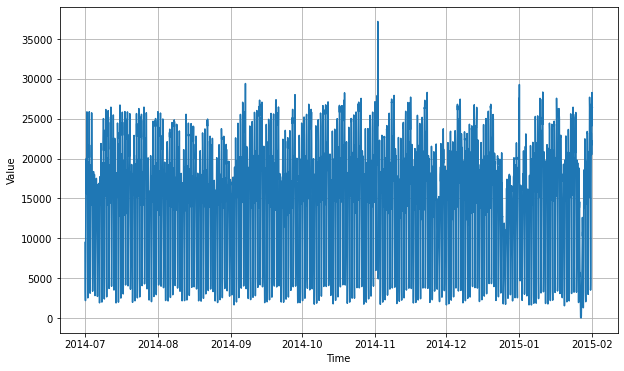

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(df['timestamp'], df['value'])

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
time = np.array(df['timestamp'])
series = np.array(df['value'])
len(df)

5160

In [ ]:
split_time = 500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 48
batch_size = 100
shuffle_buffer_size = 1000


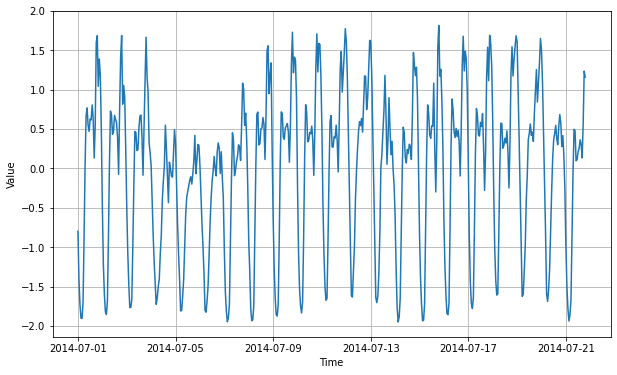

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train[:, np.newaxis])
x_train_scaled = x_train_scaled[:, -1]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train_scaled)

In [ ]:
# class PrintWeights(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     print(model.layers[0].get_weights())                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
# print_weights = PrintWeights()

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train_scaled, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(32, 10, input_shape=(window_size,1)),
  tf.keras.layers.SimpleRNN(64, return_sequences=True),
  tf.keras.layers.SimpleRNN(64, return_sequences=True),
  tf.keras.layers.SimpleRNN(64, return_sequences=True),
  tf.keras.layers.SimpleRNN(32),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: 2*x)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 39, 32)            352       
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 39, 64)            6208      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 39, 64)            8256      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 39, 64)            8256      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 32)                3104      
_________________________________________________________________
dense (Dense)                (None, 20)                660       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

In [ ]:
model.compile(loss=tf.keras.losses.Huber(delta=1.0),
              optimizer=tf.keras.optimizers.SGD(lr=0.01),
              metrics=["mae"])
history = model.fit(train_set,epochs=100, verbose=2)

Epoch 1/100
5/5 - 3s - loss: 0.8731 - mae: 1.2885
Epoch 2/100
5/5 - 0s - loss: 0.4520 - mae: 0.8182
Epoch 3/100
5/5 - 0s - loss: 0.4504 - mae: 0.8161
Epoch 4/100
5/5 - 0s - loss: 0.4392 - mae: 0.8000
Epoch 5/100
5/5 - 0s - loss: 0.4358 - mae: 0.7959
Epoch 6/100
5/5 - 0s - loss: 0.4351 - mae: 0.7927
Epoch 7/100
5/5 - 0s - loss: 0.4320 - mae: 0.7898
Epoch 8/100
5/5 - 0s - loss: 0.4354 - mae: 0.7942
Epoch 9/100
5/5 - 0s - loss: 0.4362 - mae: 0.7943
Epoch 10/100
5/5 - 0s - loss: 0.4264 - mae: 0.7813
Epoch 11/100
5/5 - 0s - loss: 0.4286 - mae: 0.7849
Epoch 12/100
5/5 - 0s - loss: 0.4286 - mae: 0.7839
Epoch 13/100
5/5 - 0s - loss: 0.4353 - mae: 0.7929
Epoch 14/100
5/5 - 0s - loss: 0.4244 - mae: 0.7783
Epoch 15/100
5/5 - 0s - loss: 0.4240 - mae: 0.7766
Epoch 16/100
5/5 - 0s - loss: 0.4230 - mae: 0.7760
Epoch 17/100
5/5 - 0s - loss: 0.4248 - mae: 0.7800
Epoch 18/100
5/5 - 0s - loss: 0.4313 - mae: 0.7880
Epoch 19/100
5/5 - 0s - loss: 0.4234 - mae: 0.7766
Epoch 20/100
5/5 - 0s - loss: 0.4214 - m

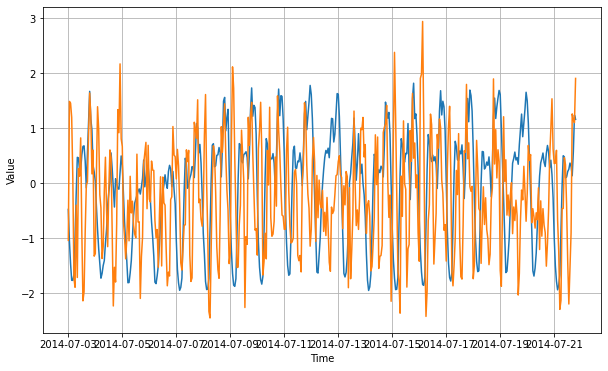

In [ ]:
forecast = model_forecast(model, series[:, np.newaxis], window_size)
forecast = forecast[:split_time - window_size]

# forecast = scaler.inverse_transform(forecast)[:,-1]
plt.figure(figsize=(10, 6))
plot_series(time_train[window_size:], x_train_scaled[window_size:])
plot_series(time_train[window_size:], forecast)

In [ ]:
forecast = scaler.inverse_transform(forecast)[:,-1]
tf.keras.metrics.mean_absolute_error(x_train[window_size:],forecast).numpy()

7425.9585

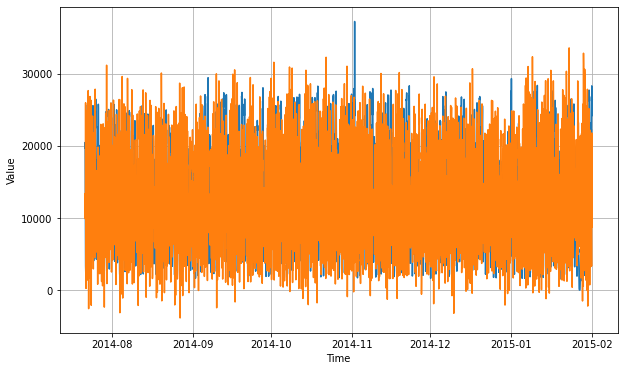

In [ ]:
forecast = model_forecast(model, series[:, np.newaxis], window_size)
forecast = forecast[split_time - window_size:-1]

forecast = scaler.inverse_transform(forecast)[:,-1]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid,forecast).numpy()

7964.7725